# This notebook is for the Fair-Shapely experiment

In [80]:
%reload_ext autoreload
%autoreload 2

### 1. Import libraries

In [81]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

### 2. Import dataset

In [82]:
from src.data.unified_dataloader import load_dataset

a, processed_compas4race= load_dataset('compas4race')

In [83]:
processed_compas4race.head(3)

,sex,age,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree_F,c_charge_degree_M,type_of_assessment_Risk of Recidivism,score_text_High,score_text_Low,score_text_Medium,two_year_recid
0,1,-0.061334,1,-0.162011,-0.195526,-0.227625,-0.735792,1,0,1,0,1,0,1
1,1,-0.901239,1,-0.162011,-0.195526,1.703263,0.059694,1,0,1,0,1,0,1
2,1,-0.985229,1,-0.162011,1.785502,-0.227625,-0.536921,1,0,1,1,0,0,0


### 3. Split label/unlabel data, split train/test data.

In [84]:
'''COMPAS for race research'''
df = processed_compas4race.copy()
X = df.drop('two_year_recid', axis=1)
y = df['two_year_recid']

# into 70% training and 30% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=25) 
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')

X_train shape: (4305, 13)
X_test shape: (1845, 13)


### 4. Train the original model

In [85]:
model = XGBClassifier()  # 可以替换为 RandomForestClassifier() 等其他模型
model.fit(X_train,y_train)

# 预测和评估
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.6742547425474255


In [86]:
X_train['race'].value_counts()

race
1    2597
0    1708
Name: count, dtype: int64

In [87]:
'''把X_train分成majority和minority两个部分'''

male_condition = X_train['race'] == 1
X_train_majority = X_train[male_condition]
y_train_majority = y_train[male_condition]

female_condition = X_train['race'] == 0
X_train_minority = X_train[female_condition]
y_train_minority = y_train[female_condition]

### 5. Evaluate the performance of original model

In [88]:
from src.attribution.oracle_metric import perturb_numpy_ver
from src.attribution import FairnessExplainer
sen_att_name = ["race"]
sen_att = [X_train.columns.get_loc(name) for name in sen_att_name]
priv_val = [1]
unpriv_dict = [list(set(X_train.values[:, sa])) for sa in sen_att]
for sa_list, pv in zip(unpriv_dict, priv_val):
    sa_list.remove(pv)
# print(f'sen_att_name:{sen_att_name}')
# print(f'sen_att:{sen_att}') # index of sensitive attribute
# print(f'priv_val:{priv_val}') # privileged value
# print(f'unpriv_dict:{unpriv_dict}') # unprivileged value(all values in the sensitive attribute, except the privileged value)



''' 
计算DR value的函数
'''
def fairness_value_function(sen_att, priv_val, unpriv_dict, X, model):
    X_disturbed = perturb_numpy_ver(
        X=X,
        sen_att=sen_att,
        priv_val=priv_val,
        unpriv_dict=unpriv_dict,
        ratio=1.0,
    )
    fx = model.predict_proba(X)[:, 1]
    fx_q = model.predict_proba(X_disturbed)[:, 1]
    return np.mean(np.abs(fx - fx_q))
original_test_DR = fairness_value_function(sen_att, priv_val, unpriv_dict, X_test.values, model)
print(f'original_test_DR: {original_test_DR}')
original_train_DR = fairness_value_function(sen_att, priv_val, unpriv_dict, X_train.values, model)
print(f'original_train_DR: {original_train_DR}')

original_test_DR: 0.09175542742013931
original_train_DR: 0.09234681725502014


### 5. 把female和male匹配，（或者male和female匹配），然后进行修改，重新训练

2025-02-07 22:17:45,862 - INFO - 3. 将X_train_minority与X_train_majority进行匹配
2025-02-07 22:17:45,960 - INFO - 4. 使用fairshap, 从X_train_majority中找到合适的值替换X_train_minority中的数据
2025-02-07 22:17:45,975 - INFO - num_full_subsets = 1
2025-02-07 22:17:45,978 - INFO - phi = array([-0.01520258,  0.        ])
2025-02-07 22:17:45,983 - INFO - num_full_subsets = 1
2025-02-07 22:17:45,986 - INFO - phi = array([-0.07248498,  0.        , -0.0706117 ])
2025-02-07 22:17:45,992 - INFO - num_full_subsets = 1
2025-02-07 22:17:45,994 - INFO - phi = array([ 0.13603754,  0.        , -0.08422744])
2025-02-07 22:17:46,022 - INFO - num_full_subsets = 1
2025-02-07 22:17:46,026 - INFO - phi = array([-0.00415704,  0.        ])
2025-02-07 22:17:46,031 - INFO - num_full_subsets = 1
2025-02-07 22:17:46,032 - INFO - phi = array([-0.20330905,  0.        ,  0.04834255])
2025-02-07 22:17:46,043 - INFO - num_full_subsets = 1
2025-02-07 22:17:46,046 - INFO - phi = array([0.1073364, 0.       ])
2025-02-07 22:17:46,053 - INFO - 

shapely value中大于0.1的值的个数有: 85


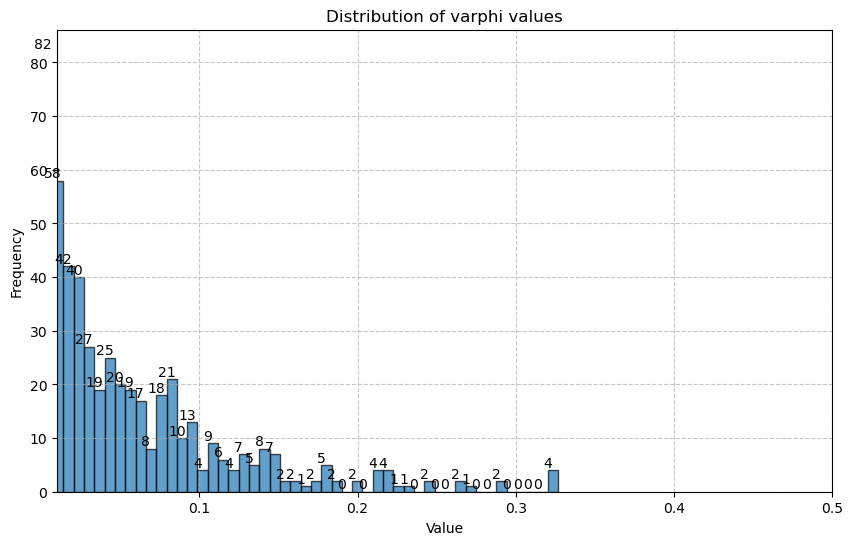

2025-02-07 22:17:55,664 - INFO - 6. 用新数据重新训练，并且评估


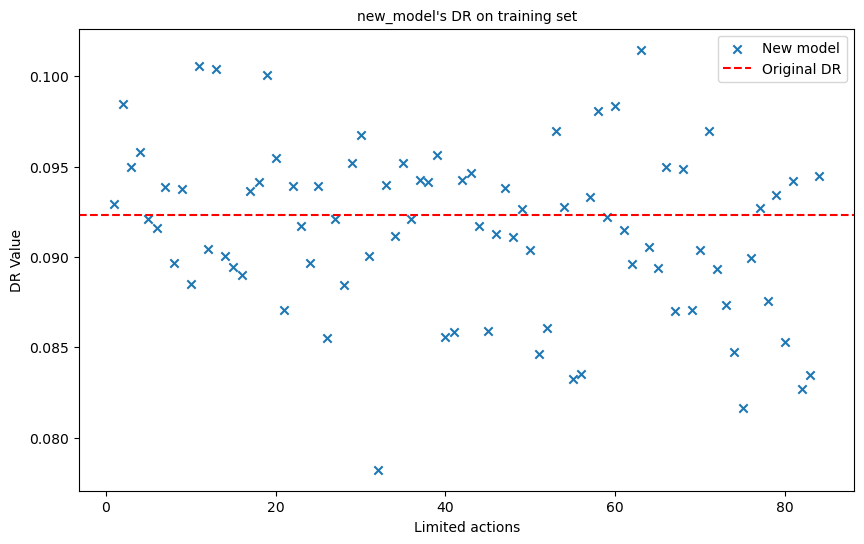

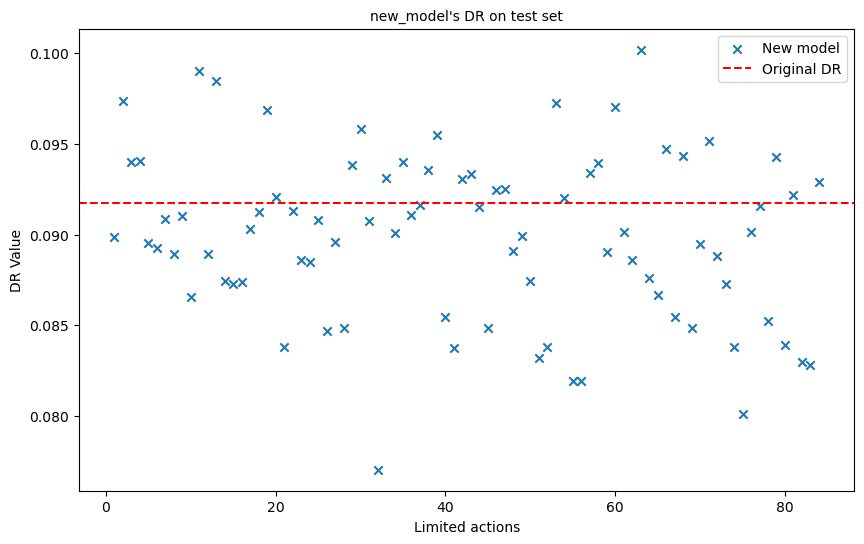

TypeError: viz2() got multiple values for argument 'title'

In [90]:
from src.experiments_approach2 import ExperimentNew

''' 改变minority group中的部分特征值'''

experiment = ExperimentNew(
                            model,
                            X_train_majority,
                            y_train_majority,
                            X_train_minority,
                            y_train_minority,
                            X_test,
                            y_test,
                            dataset_name='compas4race',
                            change_group = 'minority')
experiment.run_experiment()


3. 将X_train_minority与X_train_replace_majority进行匹配
4. 使用fairshap,把X_train_replace_majority作为baseline dataset，找到X_train_minority中需要替换的数据
未处理前非0值的个数:2617


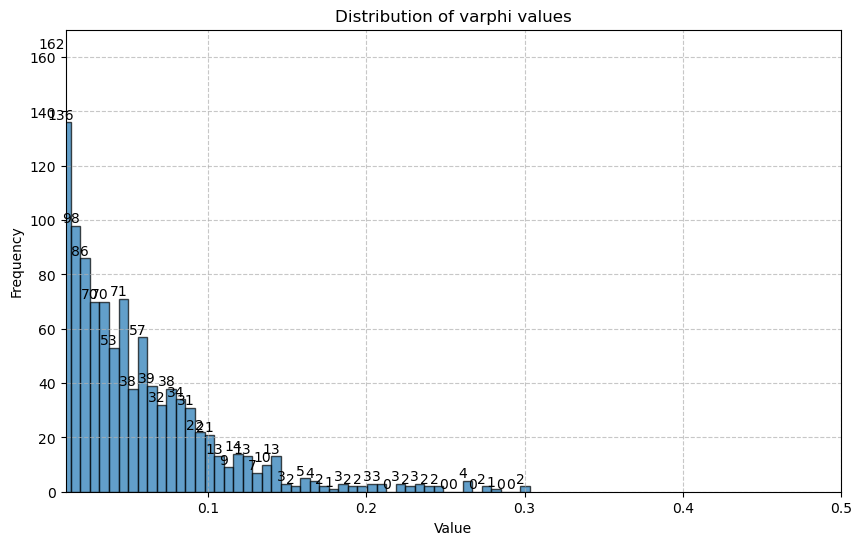

shapley value 大于0.1的值的个数:145


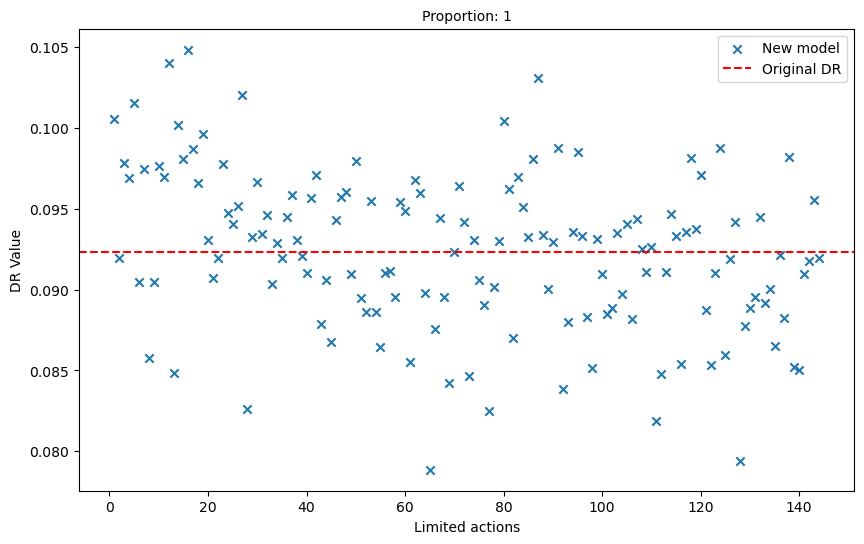

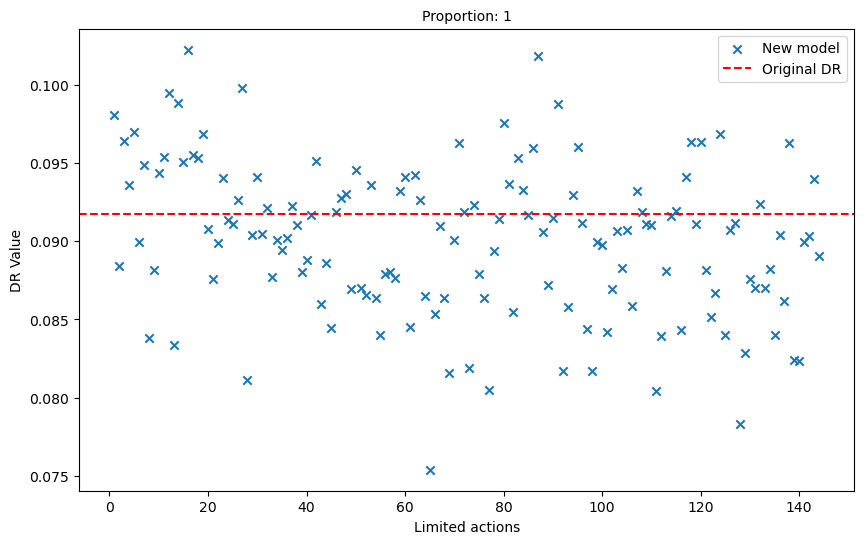

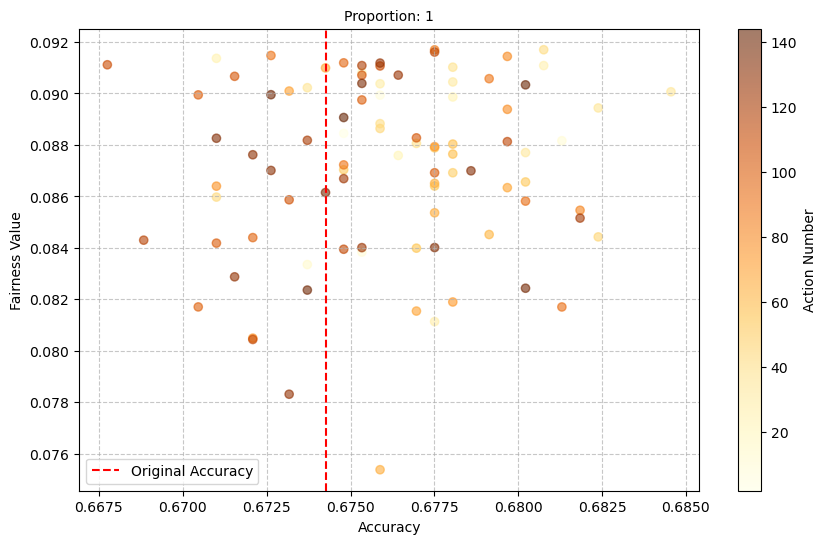

([0.098110326,
  0.08844912,
  0.09641669,
  0.093615435,
  0.097016424,
  0.08993421,
  0.09485912,
  0.083834596,
  0.088163644,
  0.09434677,
  0.09537233,
  0.0994769,
  0.08335203,
  0.09888235,
  0.09508614,
  0.10226115,
  0.09554915,
  0.095356055,
  0.096847065,
  0.09081211,
  0.087589666,
  0.08986216,
  0.094069466,
  0.09136357,
  0.091081955,
  0.0926657,
  0.09983608,
  0.08113662,
  0.09037651,
  0.09409579,
  0.09044607,
  0.09209986,
  0.087703034,
  0.09006417,
  0.089436,
  0.09022348,
  0.09226146,
  0.09101966,
  0.088059545,
  0.0888263,
  0.09169818,
  0.095115386,
  0.085972846,
  0.088638924,
  0.08442704,
  0.0918831,
  0.09276621,
  0.09304204,
  0.08691882,
  0.09459169,
  0.08703502,
  0.08656184,
  0.093577355,
  0.08640311,
  0.083989106,
  0.08788692,
  0.08803254,
  0.08764447,
  0.093206935,
  0.09411297,
  0.08451897,
  0.094211504,
  0.092642576,
  0.086507045,
  0.07538155,
  0.085363045,
  0.09099136,
  0.086340345,
  0.08154539,
  0.090093076,
  

In [79]:
''' 改变majority group中的部分特征值'''
experiment2 = ExperimentNew(
                            model,
                            X_train_majority,
                            y_train_majority,
                            X_train_minority,
                            y_train_minority,
                            X_test,
                            y_test,
                            dataset_name='compas4race',
                            change_group = 'majority')
experiment2.run_experiment()